In [1]:
# standard library
from pathlib import Path

# 3rd party
import pandas as pd

# aind
from ophys_mfish_dev.code_ocean.code_ocean_data_explorer import CodeOceanDataExplorer 
f#rom ophys_mfish_dev.code_ocean.data_asset_loader import DataAssetLoader
import ophys_mfish_dev.utils as utils

# my repo
import mdev.utils.lims_utils as lu


aws_mnt = Path('/mnt') # define folder where buckets are mounted locally


## AWS mounting notes
+ make sure aind-ophys-bucket is mounted
+ buckets found for multiplane data assets
    + aind-ophys-data
    + aind-private-data-prod-o5171v
    + aind-scratch-data (not used)

## Notes on data assets found 
+ 1 found in the stratch bucket, so I filter that out
+ 27 empty datasets

In [157]:
def raw_asset_list_to_df(asset_list):
    for asset in asset_list:
        bucket = asset['source_bucket']['bucket']
        mount_folder = asset['mount']
        session_path = aws_mnt / bucket / mount_folder

        # ophsy folder, can be wither [ophys, pophys, mpophys], check for all
        ophys_folder = utils.check_ophys_folder(session_path)

        platform_file = list(ophys_folder.glob('*platform.json'))[0]

        lims_osid = int(platform_file.name.split('_')[0])
        mount_info_dict = {'session_path': session_path,
                        'ophys_path': ophys_folder,
                        'platform_json_path': platform_file,
                        'lims_osid': lims_osid}
        
        asset.update(mount_info_dict)

    df = pd.DataFrame(asset_list)
    drops_cols = ['created', 'custom_metadata', 'description', 'last_used', 'mount', 'size', 'source_bucket','tags','type', 'files','state', 'tags']
    df = df.drop(columns=drops_cols)

    return df


def derived_asset_list_to_df(asset_list):

    df = pd.DataFrame(asset_list)
    drops_cols = ['created', 'custom_metadata', 'description', 'last_used', 'mount', 'size','type', 'files','state']
    df = df.drop(columns=drops_cols)

    # rename name to processed_name
    df = df.rename(columns={'name':'processed_name'})
    # id tp processed_id
    df = df.rename(columns={'id':'processed_id'})
    # split by _ and take 5 element as processed type
    df['processed_type'] = df['processed_name'].apply(lambda x: x.split('_')[4])

    # check all tags in list, extract tag if "pipeline" in tag
    df['pipeline'] = df['tags'].apply(lambda x: [tag for tag in x if 'pipeline' in tag])
    # drop tags
    df = df.drop(columns=['tags'])
    df['pipeline'] = df['pipeline'].apply(lambda x: x[0] if len(x) > 0 else None)

    # prefix_name = name, split on _ and take first 4 elements and rejoin
    df['prefix_name'] = df['processed_name'].apply(lambda x: '_'.join(x.split('_')[:4]))
    return df


def remove_empty_mount_folders(asset_list):
    """Some empy data folders in AWS, remove them"""
    mounted_assets = []
    not_mounted_assets = []
    for asset in asset_list:

        bucket = asset['source_bucket']['bucket']
        mount_folder = asset['mount']
        session_path = aws_mnt / bucket / mount_folder


        if not session_path.exists():
            not_mounted_assets.append(asset)
            continue
        else:
            mounted_assets.append(asset)

    return mounted_assets, not_mounted_assets

In [3]:
# 0. Make sure ENV variables are set correctly. You should add them to your bashrc file or equivalent

os.environ["CODEOCEAN_DOMAIN"] = "https://codeocean.allenneuraldynamics.org/"
os.environ["CODEOCEAN_TOKEN"] = "cop_ZDcyZjY4MDBhMGNmNDVkNGI1MjdjZTI5ODVkODU3YWJlWmhxSVV5bDR4dWxDTTVoUXJqZGF6OWViUVJXMmwxMmYyMTdmZDhj"

In [114]:
# 1. Use CODE to get assets on code ocean 
code = CodeOceanDataExplorer(query='multiplane')
ra = code.raw_assets
da = code.derived_assets
ra = [a for a in ra if a['source_bucket']['bucket'] != "aind-scratch-data"] # only 1 found in scratch
print(len(ra))
print(len(da))

CodeOceanDataExplorer initialized
---------------------------------
Query: multiplane
Number of assets: 678
473
122


In [184]:
# 2. get clean raw and derived tables

# make raw table
raw_assets, empty_assets = remove_empty_mount_folders(ra)
print(f"n_raw_assets: {len(raw_assets)}, n_empty_assets: {len(empty_assets)} dropped")

raw_table = raw_asset_list_to_df(raw_assets.copy())
len_rt = len(raw_table)
raw_table = raw_table.drop_duplicates(subset=['name'], keep='first')
print("n_raw_assets: ", len(raw_table))
print(f"dropped {len_rt - len(raw_table)} duplicates")


# make derived table
derived_table = derived_asset_list_to_df(da)
derived_table = derived_table[derived_table['processed_type'] == 'processed'].copy() # remove dlc-eye
len_dt = len(derived_table)
derived_table = derived_table.drop_duplicates(subset=['prefix_name'], keep='first')
print(f"dropped {len_dt - len(derived_table)} duplicates")
print("n_derived_assets: ", len(derived_table))
derived_table.head()

# only keep processed_type = 'processed'


n_raw_assets: 446, n_empty_assets: 27 dropped
n_raw_assets:  276
dropped 170 duplicates
dropped 15 duplicates
n_derived_assets:  96


,processed_id,processed_name,provenance,processed_type,pipeline,prefix_name
0,aa025cce-ddaf-4d43-ae30-ba1c808b7211,multiplane-ophys_726087_2024-05-07_12-05-00_pr...,{'capsule': '543b69f3-cf29-47b7-8fda-c1482557e...,processed,None,multiplane-ophys_726087_2024-05-07_12-05-00
2,20e4c466-bed7-4e67-b39a-4ebc7e379259,multiplane-ophys_729417_2024-06-03_09-27-38_pr...,NaN,processed,None,multiplane-ophys_729417_2024-06-03_09-27-38
3,91cc4000-7a02-486a-aa74-86db4619f525,multiplane-ophys_724567_2024-05-20_12-00-21_pr...,NaN,processed,None,multiplane-ophys_724567_2024-05-20_12-00-21
4,8e58cac0-61e4-43a6-a6ea-c866352afa71,multiplane-ophys_724567_2024-05-17_10-34-03_pr...,{'capsule': '56bf687b-dbcd-4b93-a650-21b858403...,processed,None,multiplane-ophys_724567_2024-05-17_10-34-03
5,41a77348-0e6c-4570-8ebc-5ffb405a4d20,multiplane-ophys_721291_2024-05-14_08-24-49_pr...,NaN,processed,None,multiplane-ophys_721291_2024-05-14_08-24-49


In [174]:
# 3. Get session table from LIMS
session_table = lu.aind_projects_sessions_table(simple=True)
session_table.head()

,ophys_session_id,mouse_id,specimen_id,date_str,session_type,equipment_name,project_code
0,839208243,431151,791871803,2019-03-19,OPHYS_1_images_A,MESO.1,VisualBehaviorMultiscope
1,839514418,431151,791871803,2019-03-20,OPHYS_2_images_A_passive,MESO.1,VisualBehaviorMultiscope
2,840490733,431151,791871803,2019-03-22,OPHYS_3_images_A,MESO.1,VisualBehaviorMultiscope
3,841303580,431151,791871803,2019-03-25,OPHYS_4_images_B,MESO.1,VisualBehaviorMultiscope
4,841778484,431151,791871803,2019-03-26,OPHYS_5_images_B_passive,MESO.1,VisualBehaviorMultiscope


In [185]:
merge_df = raw_table.merge(session_table, left_on='lims_osid', right_on='ophys_session_id', how='left')

print("n_assets: ", len(merge_df))
merge_df

n_assets:  276


,id,name,session_path,ophys_path,platform_json_path,lims_osid,ophys_session_id,mouse_id,specimen_id,date_str,session_type,equipment_name,project_code
0,fc1cdfec-f058-412d-9ec6-8d511427ee7b,multiplane-ophys_724567_2024-05-20_12-00-21,/mnt/aind-private-data-prod-o5171v/multiplane-...,/mnt/aind-private-data-prod-o5171v/multiplane-...,/mnt/aind-private-data-prod-o5171v/multiplane-...,1367710111,1.367710e+09,724567,1.343636e+09,2024-05-20,OPHYS_2_images_A_passive,MESO.1,LearningmFISHDevelopment
1,c7684348-c24c-48ea-9d62-f30bf02fd63e,multiplane-ophys_727604_2024-05-20_14-37-06,/mnt/aind-private-data-prod-o5171v/multiplane-...,/mnt/aind-private-data-prod-o5171v/multiplane-...,/mnt/aind-private-data-prod-o5171v/multiplane-...,1367735563,1.367736e+09,727604,1.342317e+09,2024-05-20,STAGE_1,MESO.1,LearningmFISHDevelopment
2,c81c506f-abee-4381-9487-b7a85379c760,multiplane-ophys_718431_2024-04-29_14-22-36,/mnt/aind-private-data-prod-o5171v/multiplane-...,/mnt/aind-private-data-prod-o5171v/multiplane-...,/mnt/aind-private-data-prod-o5171v/multiplane-...,1348672922,1.348673e+09,718431,1.329598e+09,2024-04-29,STAGE_0,MESO.1,U01BFCT
3,c968be26-48b0-4718-9131-570e9eb6c37c,multiplane-ophys_704576_2024-02-12_09-14-43,/mnt/aind-private-data-prod-o5171v/multiplane-...,/mnt/aind-private-data-prod-o5171v/multiplane-...,/mnt/aind-private-data-prod-o5171v/multiplane-...,1330132892,1.330133e+09,704576,1.315419e+09,2024-02-12,OPHYS_6_images_B,MESO.1,LearningmFISHTask1A
4,caad0eb4-654b-479a-b485-2b75e688db53,multiplane-ophys_711414_2024-03-27_11-21-35,/mnt/aind-private-data-prod-o5171v/multiplane-...,/mnt/aind-private-data-prod-o5171v/multiplane-...,/mnt/aind-private-data-prod-o5171v/multiplane-...,1340819024,1.340819e+09,711414,1.321449e+09,2024-03-27,STAGE_1,MESO.1,omFISHGad2Meso
...,...,...,...,...,...,...,...,...,...,...,...,...,...
271,61b9fcd8-4c8b-41a4-a623-f3bee9ccbbb1,multiplane-ophys_677594_2023-08-03_09-56-38,/mnt/aind-ophys-data/multiplane-ophys_677594_2...,/mnt/aind-ophys-data/multiplane-ophys_677594_2...,/mnt/aind-ophys-data/multiplane-ophys_677594_2...,1287475236,1.287475e+09,677594,1.272832e+09,2023-08-03,OPHYS_4_images_B,MESO.1,LearningmFISHTask1A
272,e19b2223-c8e0-4a57-aeeb-39e81f67ae37,multiplane-ophys_677594_2023-07-28_09-29-23,/mnt/aind-ophys-data/multiplane-ophys_677594_2...,/mnt/aind-ophys-data/multiplane-ophys_677594_2...,/mnt/aind-ophys-data/multiplane-ophys_677594_2...,1286031935,1.286032e+09,677594,1.272832e+09,2023-07-28,TRAINING_4_images_A_training,MESO.1,LearningmFISHTask1A
273,9f7e16c0-516e-442e-8042-b9738e7b16ed,multiplane-ophys_677594_2023-07-27_10-19-00,/mnt/aind-ophys-data/multiplane-ophys_677594_2...,/mnt/aind-ophys-data/multiplane-ophys_677594_2...,/mnt/aind-ophys-data/multiplane-ophys_677594_2...,1285830771,1.285831e+09,677594,1.272832e+09,2023-07-27,TRAINING_3_images_A_10uL_reward,MESO.1,LearningmFISHTask1A
274,5d448339-9518-4320-8815-92a895da47a7,multiplane-ophys_686385_2023-09-26_15-33-50,/mnt/aind-ophys-data/multiplane-ophys_686385_2...,/mnt/aind-ophys-data/multiplane-ophys_686385_2...,/mnt/aind-ophys-data/multiplane-ophys_686385_2...,1299751969,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [186]:
# count by project_code
merge_df['project_code'].value_counts()

VisualBehaviorMultiscope4areasx2d    99
LearningmFISHTask1A                  77
LearningmFISHDevelopment             64
VisualBehaviorMultiscope             26
omFISHGad2Meso                        5
U01BFCT                               4
Name: project_code, dtype: int64

In [187]:
# merge with derived
final_df = merge_df.merge(derived_table, left_on='name', right_on='prefix_name', how='left')
print("n_assets: ", len(final_df))

n_assets:  276


In [172]:
merge_df[merge_df.duplicated(subset='name', keep=False)]

,id,name,session_path,ophys_path,platform_json_path,lims_osid,ophys_session_id,mouse_id,specimen_id,date_str,session_type,equipment_name,project_code


In [167]:
raw_table[raw_table.duplicated(subset='name', keep=False)]

,id,name,session_path,ophys_path,platform_json_path,lims_osid


In [183]:
derived_table[derived_table.duplicated(subset='prefix_name', keep=False)].iloc[0]

processed_id                   3ea14e5c-66bd-42c7-8545-7c6e59a2337e
processed_name    multiplane-ophys_729417_2024-05-29_08-55-18_pr...
provenance                                                      NaN
processed_type                                            processed
pipeline                                                       None
prefix_name             multiplane-ophys_729417_2024-05-29_08-55-18
Name: 14, dtype: object

In [188]:
final_df[final_df.duplicated(subset='name', keep=False)]

,id,name,session_path,ophys_path,platform_json_path,lims_osid,ophys_session_id,mouse_id,specimen_id,date_str,session_type,equipment_name,project_code,processed_id,processed_name,provenance,processed_type,pipeline,prefix_name


# Plots

In [42]:
project_code_count

,on_code_ocean,lims_count,percent,not_uploaded
project_code,,,,
VisualBehaviorMultiscope4areasx2d,99,186,0.532258,87
LearningmFISHDevelopment,64,242,0.264463,178
LearningmFISHTask1A,77,486,0.158436,409
VisualBehaviorMultiscope,26,302,0.086093,276
omFISHGad2Meso,5,113,0.044248,108
U01BFCT,4,128,0.031250,124


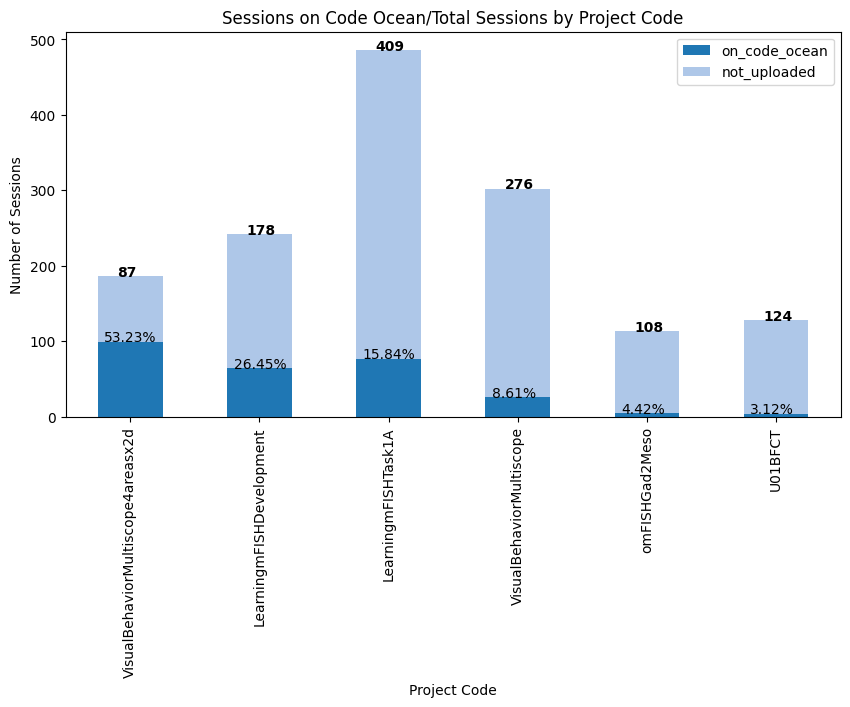

In [53]:
# get count of project codes in merge_df and session_table and combine
project_code_count = merge_df['project_code'].value_counts()
project_code_count = project_code_count.reset_index()
project_code_count.columns = ['project_code', 'on_code_ocean']
project_code_count = project_code_count.set_index('project_code')
project_code_count = project_code_count.join(session_table['project_code'].value_counts())
project_code_count = project_code_count.rename(columns={'project_code':'lims_count'})
project_code_count = project_code_count.fillna(0)
project_code_count = project_code_count.astype(int)
# calc percent
project_code_count['percent'] = project_code_count['on_code_ocean'] / project_code_count['lims_count']
# calc lims - asset count
project_code_count['not_uploaded'] = project_code_count['lims_count'] - project_code_count['on_code_ocean']
project_code_count = project_code_count.sort_values(by='percent', ascending=False)

# plot stacked bar chart
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10,5))
# plot stacked bar chart, lims_count = total number of sessions in lims, on_code_ocean = number of assets in code ocean
# make pretty colors for two bars, blues
colors = ['#1f77b4', '#aec7e8']
project_code_count[['on_code_ocean','not_uploaded']].plot(kind='bar', stacked=True, ax=ax, color=colors)

# add project_code_count['percent'] to bottom of bar, and 'not_uploaded' to top of bar
for i, v in enumerate(project_code_count['percent']):
    ax.text(i-0.2, v + project_code_count['on_code_ocean'][i], str(round(v*100, 2))+'%', color='black')
    ax.text(i-.1, v + project_code_count['lims_count'][i], str(project_code_count['not_uploaded'][i]), color='black', fontweight='bold')

# ylim n sessions
# xlim project_code
ax.set_ylabel('Number of Sessions')
ax.set_xlabel('Project Code')
ax.set_title('Sessions on Code Ocean/Total Sessions by Project Code')


plt.show()


## key processed

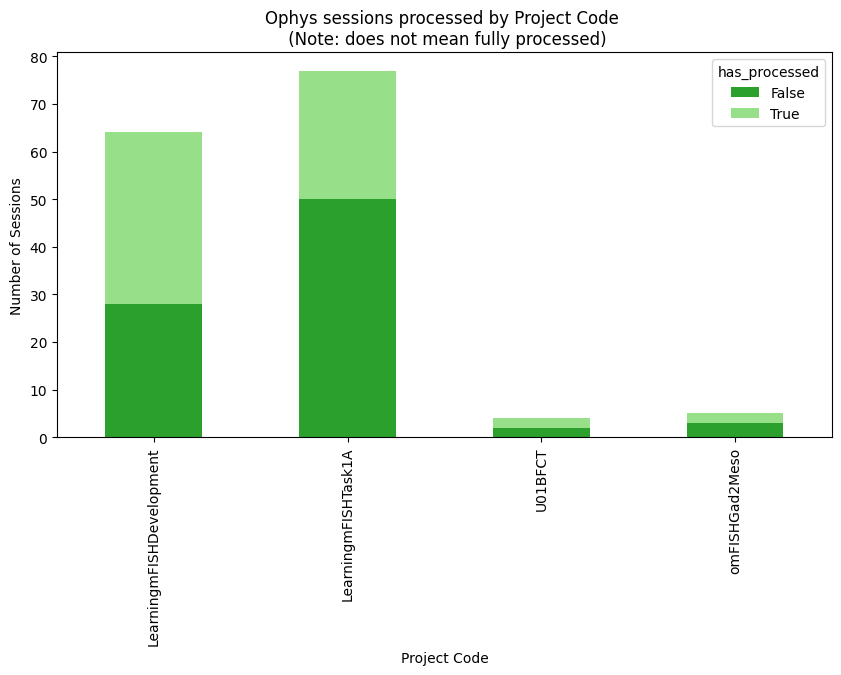

In [189]:
# drop VisualBehaviorMultiscope4areasx2d,VisualBehaviorMultiscope
processed_df = final_df[~final_df['project_code'].isin(['VisualBehaviorMultiscope4areasx2d','VisualBehaviorMultiscope'])].copy()
processed_df.project_code.value_counts()

# if processed_name notnan add new col has_processed = True, prevent set copy warning
processed_df['has_processed'] = processed_df['processed_name'].notna()

# make stacked count plot of has_processed by project_code
fig, ax = plt.subplots(figsize=(10,5))
# make pretty colors for two bars, greens
colors = ['#2ca02c', '#98df8a']
processed_df.groupby(['project_code','has_processed']).size().unstack().plot(kind='bar', stacked=True, ax=ax, color=colors)

ax.set_ylabel('Number of Sessions')
ax.set_xlabel('Project Code')
ax.set_title('Ophys sessions processed by Project Code \n (Note: does not mean fully processed)')


plt.show()

# Pipeline versions

In [113]:
# do count of pipeline
processed_df['pipeline'].value_counts()


pipeline-v3.0    53
Name: pipeline, dtype: int64

# Individual mice

In [10]:
# , vip-cre, VBM NOTE: this mouse has duplicate sessions uploaded
mouse_id = '563231'

# lamf + omfish, gad2-cre
mouse_id = '677594' # lead mouse
mouse_id = '681417' # tin mouse

def mouse_sessions(mouse_id, df):
    # get all sessions for mouse_id
    mouse_sessions = df[merge_df['mouse_id'] == mouse_id]
    mouse_sessions = mouse_sessions.sort_values(by='date_str')

    return mouse_sessions

mouse_df = mouse_sessions(mouse_id, merge_df).reset_index(drop=True)
print(mouse_df[['id','name']].to_csv())

,id,name
0,89421805-ed71-487a-aac7-917cb9c1f899,multiplane-ophys_681417_2023-07-12_10-06-22
1,8aa984c6-9fc5-465c-9bc7-373a232c8283,multiplane-ophys_681417_2023-07-13_10-10-43
2,2a96c6c6-2f52-4f76-a18b-c3855be28874,multiplane-ophys_681417_2023-07-14_10-05-10
3,00e71d71-0a88-4ecd-ba81-6df542d120c0,multiplane-ophys_681417_2023-07-14_10-05-10
4,24876419-b80f-4ae2-9772-2be0c554e6c7,multiplane-ophys_681417_2023-07-17_10-17-38
5,74de10a8-bc4a-4422-91de-ae496b0739fe,multiplane-ophys_681417_2023-07-17_10-17-38
6,02d3dedf-5722-438b-82cf-f957a0e9b220,multiplane-ophys_681417_2023-07-18_10-56-26
7,977de373-b163-4567-b17d-1f7141c7d502,multiplane-ophys_681417_2023-07-18_10-56-26
8,833a6494-1a9f-4ac1-835e-841caad8dd74,multiplane-ophys_681417_2023-07-18_10-56-26
9,cf251b85-2444-4180-97b8-637629213494,multiplane-ophys_681417_2023-07-19_10-33-35
10,d80e7895-cbc6-46b6-9cf9-22a3ac75ae0f,multiplane-ophys_681417_2023-07-20_09-59-08
11,ab53c592-dbdb-40a8-95a4-54b64dbebcea,multiplane-ophys_681417_2023-07-24_09

In [11]:
mouse_df

,id,name,session_path,ophys_path,platform_json_path,lims_osid,ophys_session_id,mouse_id,specimen_id,date_str,session_type,equipment_name,project_code
0,89421805-ed71-487a-aac7-917cb9c1f899,multiplane-ophys_681417_2023-07-12_10-06-22,/mnt/aind-ophys-data/multiplane-ophys_681417_2...,/mnt/aind-ophys-data/multiplane-ophys_681417_2...,/mnt/aind-ophys-data/multiplane-ophys_681417_2...,1282480118,1.282480e+09,681417,1.274325e+09,2023-07-12,TRAINING_0_gratings_autorewards_15min,MESO.2,LearningmFISHTask1A
1,8aa984c6-9fc5-465c-9bc7-373a232c8283,multiplane-ophys_681417_2023-07-13_10-10-43,/mnt/aind-ophys-data/multiplane-ophys_681417_2...,/mnt/aind-ophys-data/multiplane-ophys_681417_2...,/mnt/aind-ophys-data/multiplane-ophys_681417_2...,1282665200,1.282665e+09,681417,1.274325e+09,2023-07-13,TRAINING_1_gratings,MESO.2,LearningmFISHTask1A
2,2a96c6c6-2f52-4f76-a18b-c3855be28874,multiplane-ophys_681417_2023-07-14_10-05-10,/mnt/aind-ophys-data/multiplane-ophys_681417_2...,/mnt/aind-ophys-data/multiplane-ophys_681417_2...,/mnt/aind-ophys-data/multiplane-ophys_681417_2...,1282892466,1.282892e+09,681417,1.274325e+09,2023-07-14,TRAINING_1_gratings,MESO.2,LearningmFISHTask1A
3,00e71d71-0a88-4ecd-ba81-6df542d120c0,multiplane-ophys_681417_2023-07-14_10-05-10,/mnt/aind-ophys-data/multiplane-ophys_681417_2...,/mnt/aind-ophys-data/multiplane-ophys_681417_2...,/mnt/aind-ophys-data/multiplane-ophys_681417_2...,1282892466,1.282892e+09,681417,1.274325e+09,2023-07-14,TRAINING_1_gratings,MESO.2,LearningmFISHTask1A
4,24876419-b80f-4ae2-9772-2be0c554e6c7,multiplane-ophys_681417_2023-07-17_10-17-38,/mnt/aind-ophys-data/multiplane-ophys_681417_2...,/mnt/aind-ophys-data/multiplane-ophys_681417_2...,/mnt/aind-ophys-data/multiplane-ophys_681417_2...,1283445129,1.283445e+09,681417,1.274325e+09,2023-07-17,TRAINING_2_gratings_flashed,MESO.2,LearningmFISHTask1A
5,74de10a8-bc4a-4422-91de-ae496b0739fe,multiplane-ophys_681417_2023-07-17_10-17-38,/mnt/aind-ophys-data/multiplane-ophys_681417_2...,/mnt/aind-ophys-data/multiplane-ophys_681417_2...,/mnt/aind-ophys-data/multiplane-ophys_681417_2...,1283445129,1.283445e+09,681417,1.274325e+09,2023-07-17,TRAINING_2_gratings_flashed,MESO.2,LearningmFISHTask1A
6,02d3dedf-5722-438b-82cf-f957a0e9b220,multiplane-ophys_681417_2023-07-18_10-56-26,/mnt/aind-ophys-data/multiplane-ophys_681417_2...,/mnt/aind-ophys-data/multiplane-ophys_681417_2...,/mnt/aind-ophys-data/multiplane-ophys_681417_2...,1283799929,1.283800e+09,681417,1.274325e+09,2023-07-18,TRAINING_3_images_A_10uL_reward,MESO.2,LearningmFISHTask1A
7,977de373-b163-4567-b17d-1f7141c7d502,multiplane-ophys_681417_2023-07-18_10-56-26,/mnt/aind-ophys-data/multiplane-ophys_681417_2...,/mnt/aind-ophys-data/multiplane-ophys_681417_2...,/mnt/aind-ophys-data/multiplane-ophys_681417_2...,1283799929,1.283800e+09,681417,1.274325e+09,2023-07-18,TRAINING_3_images_A_10uL_reward,MESO.2,LearningmFISHTask1A
8,833a6494-1a9f-4ac1-835e-841caad8dd74,multiplane-ophys_681417_2023-07-18_10-56-26,/mnt/aind-ophys-data/multiplane-ophys_681417_2...,/mnt/aind-ophys-data/multiplane-ophys_681417_2...,/mnt/aind-ophys-data/multiplane-ophys_681417_2...,1283799929,1.283800e+09,681417,1.274325e+09,2023-07-18,TRAINING_3_images_A_10uL_reward,MESO.2,LearningmFISHTask1A
9,cf251b85-2444-4180-97b8-637629213494,multiplane-ophys_681417_2023-07-19_10-33-35,/mnt/aind-ophys-data/multiplane-ophys_681417_2...,/mnt/aind-ophys-data/multiplane-ophys_681417_2...,/mnt/aind-ophys-data/multiplane-ophys_681417_2...,1284023946,1.284024e+09,681417,1.274325e+09,2023-07-19,TRAINING_3_images_A_10uL_reward,MESO.2,LearningmFISHTask1A


In [66]:
# groupby mouse_id
# get just VisualBehaviorMultiscope4areasx2d

vb = merge_df[merge_df['project_code'] == 'VisualBehaviorMultiscope4areasx2d']
vb['mouse_id'].value_counts()

481295    19
554115    18
513630    18
563234    17
563231    17
524158    17
561443    17
484408    16
472271    16
484631    15
550603    15
555970    15
489065    15
485689    14
477052    13
499478     9
570949     7
Name: mouse_id, dtype: int64

In [74]:
vb = merge_df[merge_df['project_code'] == 'LearningmFISHTask1A']
vb['mouse_id'].value_counts()

677594    22
711414    21
681417    21
671833     5
612764     3
636496     3
704576     2
639224     2
721291     1
629294     1
603892     1
Name: mouse_id, dtype: int64

# Processed

In [8]:
code = CodeOceanDataExplorer(query='multiplane')
da = code.derived_assets

print(len(da))

CodeOceanDataExplorer initialized
---------------------------------
Query: multiplane
Number of assets: 659
112


In [9]:
da

[{'created': 1711059896,
  'description': '',
  'files': 1,
  'id': '3efbe817-5a8c-43fe-b328-feea61aa78ad',
  'last_used': 1711059898,
  'mount': 'multiplane-ophys_485152_2019-12-09_13-04-09_dlc-eye_2024-03-15_21-19-18',
  'name': 'multiplane-ophys_485152_2019-12-09_13-04-09_dlc-eye_2024-03-15_21-19-18',
  'provenance': {'capsule': '4cf0be83-2245-4bb1-a55c-a78201b14bfe',
   'commit': '4bf92b004f2e37a2d8496b43f79d28dfdca5b062',
   'data_assets': ['05529cfc-23fe-4ead-9490-71763e9f7c01',
    'c65a4625-8b3b-4d3a-b300-a6f659cbcc3b'],
   'docker_image': 'cb357fec-be48-4122-b016-b71fb9f1a8ba',
   'run_script': 'code/run'},
  'size': 2066403,
  'state': 'ready',
  'tags': ['derived', 'dlc-eye', 'ophys-mfish'],
  'type': 'result'},
 {'created': 1716095556,
  'custom_metadata': {'data level': 'derived',
   'experiment type': 'multiplane-ophys',
   'subject id': '724567'},
  'description': '',
  'files': 31,
  'id': '8e58cac0-61e4-43a6-a6ea-c866352afa71',
  'last_used': 1716095745,
  'mount': 'mu